<a href="https://colab.research.google.com/github/AilingLiu/Inferential_Statistics/blob/master/ANOVA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Quantitative associations: ANOVA

## One way anova

An analysis of variance or ANOVA allows the comparison of several means of several groups. An ANOVA is often used when you deal with more than 2 groups. It uses F statistic to evaluate the variability between groups relative to the variability within groups.

> Example
<br>We are interested in the sepal length in different species in `iris` dataset. 

> Null Hypothesis
<br>$H_o$: the average sepal length is the same among different species

In [2]:
import seaborn as sns
iris = sns.load_dataset('iris')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


[Text(0.5, 1.0, 'virginica sepal length')]

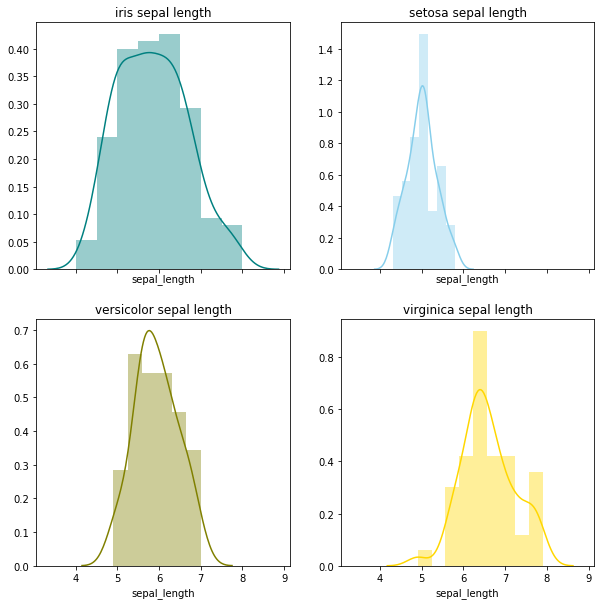

In [0]:
import matplotlib.pyplot as plt

f, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True)
sns.distplot(iris["sepal_length"] , color="teal", bins=np.linspace(4,8,9), ax=axes[0, 0])
axes[0, 0].set(title='iris sepal length')
sns.distplot(iris["sepal_length"][iris.species=='setosa'] , color="skyblue", ax=axes[0, 1])
axes[0, 1].set(title='setosa sepal length')
sns.distplot(iris["sepal_length"][iris.species=='versicolor'] , color="olive", ax=axes[1, 0])
axes[1, 0].set(title='versicolor sepal length')
sns.distplot(iris["sepal_length"][iris.species=='virginica'] , color="gold", ax=axes[1, 1])
axes[1, 1].set(title='virginica sepal length')

In [0]:
#check the summary of each species
gb = iris.groupby(['species'])['sepal_length'].describe()
gb

,count,mean,std,min,25%,50%,75%,max
species,,,,,,,,
setosa,50.0,5.006,0.352490,4.3,4.800,5.0,5.2,5.8
versicolor,50.0,5.936,0.516171,4.9,5.600,5.9,6.3,7.0
virginica,50.0,6.588,0.635880,4.9,6.225,6.5,6.9,7.9


From the summary table, each species have different average sepal length. The gives first impression that the our null hypothesis is not right. We will check the significance to validate our assumption.

We also need to check if the group size is equal in each species to determine the formulas of calculating within gorup variances. Here the group size is equal.

In [0]:
g = 3 #number of group
n = 50 #number of size of individual group
grandmean = iris.sepal_length.mean()

mswithin = sum(gb['std']**2)/g
msbetween = sum(n*(gb['mean']-grandmean)**2)/(g-1)
Fstat=msbetween/mswithin
pval = 1-st.f.cdf(Fstat, (g-1), (n*g-g))

print(f'The F statistics is {Fstat:.4f} and P value is {pval:.4f}')

The F statistics is 119.2645 and P value is 0.0000


Here our p value is close to 0. The chances that we will obtain this data under null hypothesis is extremely low. This means that there is a difference in sepal length for the different species. However, we don't know yet which species differ significantly.

In statsmodels, we can conduct anova test using [anova_lm](https://www.statsmodels.org/stable/generated/statsmodels.stats.anova.anova_lm.html) function. Before that, we will need to build a multiple regression model using ols function. In fact, multiple regression and analysis of variance are technically the same. In the anoval_lm function, you need to specify the type of anova. You can check details [here](https://stackoverflow.com/questions/55175274/uses-of-typ-in-anova-lm). After the test, we can use the summary function from ols object to evaluate each parameter's significance and the model significance.

In [0]:
iris_ols=smf.ols('sepal_length ~ C(species)', data=iris).fit() #Specify C for Categorical
test_result = sm.stats.anova_lm(iris_ols, typ=2)
test_result

,sum_sq,df,F,PR(>F)
C(species),63.212133,2.0,119.264502,1.669669e-31
Residual,38.956200,147.0,NaN,NaN


In [0]:
print(iris_ols.summary())

                            OLS Regression Results                            
Dep. Variable:           sepal_length   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     119.3
Date:                Fri, 14 Feb 2020   Prob (F-statistic):           1.67e-31
Time:                        16:37:02   Log-Likelihood:                -111.73
No. Observations:                 150   AIC:                             229.5
Df Residuals:                     147   BIC:                             238.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

## Assumptions checking anova

1.  The population distribution for the dependent variable for each of the g groups need to be approximately normal. We can use [Shapiro Walk Test](https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test) in python [shapiro](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html) function.
2.  Those distributions for each of the groups have the same standard deviation (homogeneity of variances). We can use [Barlett's Test](https://en.wikipedia.org/wiki/Bartlett%27s_test) in python [barlett](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.bartlett.html) function.
3. No correlation between the residual (error) terms. (aka. no autocorrelation)
4. The data resulted from randomization

<Figure size 360x288 with 0 Axes>

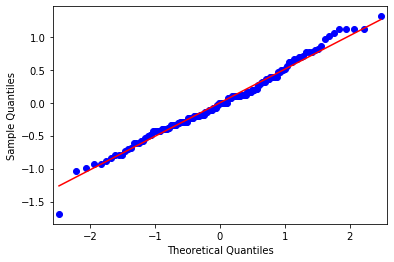

In [0]:
import matplotlib.pyplot as plt
res = iris_ols.resid 
fig =plt.figure(figsize=(5,4))
ax = sm.qqplot(res, line='s')
plt.show()

In [0]:
#normality test
stat, p = st.shapiro(iris['sepal_length'])
print('Normality Test: Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)\n')
 
#homogeneity
setosa = iris["sepal_length"][iris.species=='setosa']
versicolor = iris["sepal_length"][iris.species=='versicolor']
virginica = iris["sepal_length"][iris.species=='virginica']
stat, p = st.bartlett(setosa, versicolor, virginica)
print('Homogeneity Test: Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
alpha = 0.05
if p > alpha:
	print('Sample has the same variances (fail to reject H0)')
else:
	print('Sample does not have the same variances (reject H0)')


Normality Test: Statistics=0.976, p=0.010
Sample does not look Gaussian (reject H0)

Homogeneity Test: Statistics=16.006, p=0.000
Sample does not have the same variances (reject H0)


From the plots, there is an outlier that deviate from the straight line. Other than that, the residuals are clustered along with the straight line. The shapiro normality test concludes p=0.1, which does not meet assumption at 0.05 significance level. Homogeneity of variance are not met either. We can clean up the data and rerun the test again. Otherwise, we should use non parametric test instead of anova test. We will cover it in another notebook. Our purpose here is to learn how to conduct the anova test in python. 

Another way to check the assumption is to read the summary statistics directly from the ols summary table. The [Durban-Watson tests](https://www.investopedia.com/terms/d/durbin-watson-statistic.asp) is to detect the presence of autocorrelation, [Jarque-Bera tests](https://www.statisticshowto.datasciencecentral.com/jarque-bera-test/) the assumption of normality, Omnibus tests the assumption of homogeneity of variance, and the Condition Number assess multicollinearity. Condition Number values over 20 are indicative of multicollinearity. The model does not pass the assumption check of homogeneity, normality as tested before. [More details Here](https://www.geeksforgeeks.org/interpreting-the-results-of-linear-regression-using-ols-summary/).

## Post hoc analysis

There are multiple way to do the post hoc analysis. One of it is the bonferroni correction post hoc comparison where the family-wise error rate is less than or equal to the initial overall significance rate. But this method could be overly conservative. Another one is TukeyHSD post hoc test, where the family-wise error rate is similar to the overal significance rate. This test generally has a narrower confidence interval.

In [0]:
from statsmodels.stats.multicomp import MultiComparison

mc = MultiComparison(iris['sepal_length'], iris['species'])
mc_results = mc.tukeyhsd()
print(mc_results)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1     group2   meandiff p-adj lower  upper  reject
---------------------------------------------------------
    setosa versicolor     0.93 0.001 0.6862 1.1738   True
    setosa  virginica    1.582 0.001 1.3382 1.8258   True
versicolor  virginica    0.652 0.001 0.4082 0.8958   True
---------------------------------------------------------


From the difference, we can see that $\mu_{versicolor}-\mu_{setosa}=0.93$ and $\mu_{setosa} - \mu_{virginica}=1.582$.
The `meandiff` in these two comparisons correspond to the multiple regression coefficients we just did. The species `setosa` is a reference group integrated in intercept in the regression model. More details you can review the course.



## Two way anova

A two-way anova is used when you want to compare multiple groups across multiple independent variables. In below example, we cut the `sepal_width` to 1 to 4 categories. We will use this together with species as independent variables to check its differences in `sepal_length`.


**Null Hypothesis**
*  Avereage sepal length is the same across sepal width categories
*  Average sepal length is the same across species
*  sepal width and species are independent of each other

In [3]:
import seaborn as sns
iris = sns.load_dataset('iris')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [12]:
iris['sepal_width_cat']=pd.qcut(iris['sepal_width'], q=4, labels=[1,2,3,4])
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species,sepal_width_cat
0,5.1,3.5,1.4,0.2,setosa,4
1,4.9,3.0,1.4,0.2,setosa,2
2,4.7,3.2,1.3,0.2,setosa,3
3,4.6,3.1,1.5,0.2,setosa,3
4,5.0,3.6,1.4,0.2,setosa,4


In [13]:
iris_ols=smf.ols('sepal_length ~ C(sepal_width_cat)*C(species)', data=iris).fit() #This will also automatically include the main effects for each factor
test_result = sm.stats.anova_lm(iris_ols, typ=2)
test_result

,sum_sq,df,F,PR(>F)
C(sepal_width_cat),8.326110,3.0,13.094203,1.416468e-07
C(species),63.898989,2.0,150.737797,1.946070e-35
C(sepal_width_cat):C(species),1.380424,6.0,1.085474,3.741667e-01
Residual,29.249666,138.0,NaN,NaN


Assume we use 0.05 significance level, we have p value smaller than significance level for both sepal width and species, which means, there is a difference in sepal length across sepal width group and species group. 

The interaction term is significant. This indicates that there is interaction effect between the sepal width and their species kind. 

If we have observd the interaction term not significant, it should be removed from the model and it needs to be re-ran so we can look at the main effects of each factor independently, as we did before, but changing the formula to `response~C(facotor1)+C(factor2)`

In [14]:
print(iris_ols.summary())

                            OLS Regression Results                            
Dep. Variable:           sepal_length   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     31.28
Date:                Tue, 18 Feb 2020   Prob (F-statistic):           3.19e-32
Time:                        10:53:49   Log-Likelihood:                -90.233
No. Observations:                 150   AIC:                             204.5
Df Residuals:                     138   BIC:                             240.6
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

The overall model p value is 3.19e-32, so the model is significant. The R-squaredis 0.714, showing our model explained 71.4% of the variances in the data.
There test of assumptions from the anova table did not pass the multicollinearity test being Cond.No over 51.8. We should do a chi-square test to check the two categorical independent variables association. Here, we will continue to do the post hoc testing to see which level shows different sepal length.


## Post hoc testing

[Text(0.5, 1.0, 'sepal width 4 sepal length')]

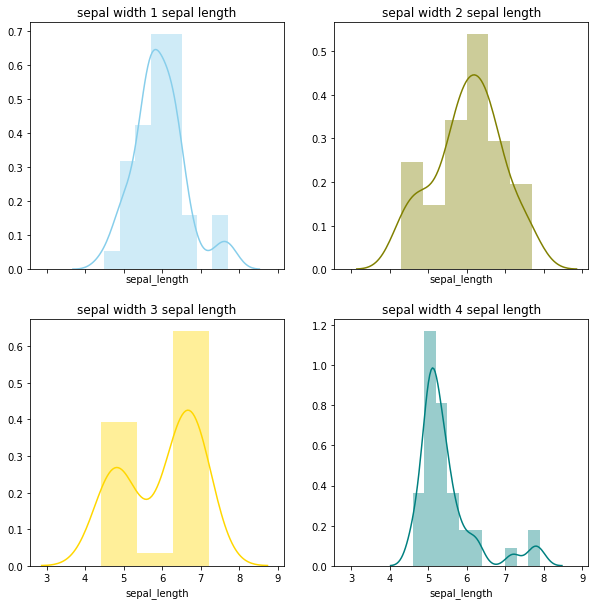

In [25]:
import matplotlib.pyplot as plt

f, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True)
sns.distplot(iris["sepal_length"][iris['sepal_width_cat']==1] , color="skyblue", ax=axes[0, 0])
axes[0, 0].set(title='sepal width 1 sepal length')
sns.distplot(iris["sepal_length"][iris['sepal_width_cat']==2] , color="olive", ax=axes[0, 1])
axes[0, 1].set(title='sepal width 2 sepal length')
sns.distplot(iris["sepal_length"][iris['sepal_width_cat']==3] , color="gold", ax=axes[1, 0])
axes[1, 0].set(title='sepal width 3 sepal length')
sns.distplot(iris["sepal_length"][iris['sepal_width_cat']==4] , color="teal", ax=axes[1, 1])
axes[1, 1].set(title='sepal width 4 sepal length')


In [18]:
from statsmodels.stats.multicomp import MultiComparison

mc = MultiComparison(iris['sepal_length'], iris['species'])
mc_results = mc.tukeyhsd()
print(mc_results)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1     group2   meandiff p-adj lower  upper  reject
---------------------------------------------------------
    setosa versicolor     0.93 0.001 0.6862 1.1738   True
    setosa  virginica    1.582 0.001 1.3382 1.8258   True
versicolor  virginica    0.652 0.001 0.4082 0.8958   True
---------------------------------------------------------


There is a statistically significant difference in the mean sepal length between speies. The sepal length in versicolor is 0.93 more than setosa, while virginica species has 1.582 average more than setosa, and 0.652 more than versicolor.

In [19]:
from statsmodels.stats.multicomp import MultiComparison

mc = MultiComparison(iris['sepal_length'], iris['sepal_width_cat'])
mc_results = mc.tukeyhsd()
print(mc_results)


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     1      2    0.098    0.9 -0.3652  0.5612  False
     1      3   0.0369    0.9 -0.4518  0.5256  False
     1      4  -0.4757 0.0395 -0.9354 -0.0161   True
     2      3  -0.0611    0.9 -0.5781  0.4559  False
     2      4  -0.5737 0.0145 -1.0633 -0.0841   True
     3      4  -0.5126 0.0508 -1.0264  0.0012  False
----------------------------------------------------


Sepal width group 1 and 4 are statistically different in sepal length, group 1 is 0.4757 longer in sepal length than group 4; similarly, sepal width group 2 and 4 are statistically different in sepal length, group 2 is 0.5737 longer in sepal length than group 4.